In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.fft import fft

In [2]:
saved_dict = {}

In [3]:
# we will now read all the datasets
file_path = 'UNSW Dataset for Testing\\NUSW-NB15_features.csv'
df_col = pd.read_csv(file_path,encoding = 'ISO-8859-1')

In [4]:
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ','').lower()) # column names become lowercase and removing spaces 

In [5]:
data = pd.read_csv('UNSW Dataset for Testing\\UNSW-NB15_1.csv')

C:\Users\Khush Bhuta\AppData\Local\Temp\ipykernel_11652\332748598.py:1: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('UNSW Dataset for Testing\\UNSW-NB15_1.csv')


In [6]:
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()

In [7]:
data.columns = df_col['Name']

In [8]:
data.shape

(700000, 49)

In [9]:
# libraries for pre-processing the data
import pickle
from prettytable import PrettyTable

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score,confusion_matrix,make_scorer
from sklearn.metrics import auc,f1_score,roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate,cross_val_predict

In [10]:
train,test = train_test_split(data,test_size = 0.3, random_state = 16)
print(train.shape,'\n',test.shape)

(490000, 49) 
 (210000, 49)


In [11]:
train.isnull().sum()

Name
srcip                    0
sport                    0
dstip                    0
dsport                   0
proto                    0
state                    0
dur                      0
sbytes                   0
dbytes                   0
sttl                     0
dttl                     0
sloss                    0
dloss                    0
service                  0
sload                    0
dload                    0
spkts                    0
dpkts                    0
swin                     0
dwin                     0
stcpb                    0
dtcpb                    0
smeansz                  0
dmeansz                  0
trans_depth              0
res_bdy_len              0
sjit                     0
djit                     0
stime                    0
ltime                    0
sintpkt                  0
dintpkt                  0
tcprtt                   0
synack                   0
ackdat                   0
is_sm_ips_ports          0
ct_state_ttl           

In [12]:
train['attack_cat'].value_counts()

attack_cat
Generic           5233
Exploits          3812
 Fuzzers          3537
Reconnaissance    1210
DoS                836
Analysis           374
Backdoors          369
Shellcode          161
Worms               17
Name: count, dtype: int64

In [13]:
train['attack_cat'] = train.attack_cat.fillna(value = 'normal').apply(lambda x: x.strip().lower())

# Exploring the dataset

In [14]:
train.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object', name='Name')

the dataset only has 0-1 values for classification. It doesn't have specific labels for IoT Devices

Class 0 - Non attack Devices
Class 1 - Attack Devices

In [15]:
train_0, train_1 = train['label'].value_counts()[0]/len(train.index), train['label'].value_counts()[1]/len(train.index)
test_0, test_1 = test['label'].value_counts()[0]/len(test.index), train['label'].value_counts()[1]/len(test.index)

In [16]:
print('Train (Class 0): ',train_0,'\nTrain (Class 1): ',train_1)
print('Test (Class 0): ',test_0,'\nTest (Class 1): ',test_1)

Train (Class 0):  0.9682673469387755 
Train (Class 1):  0.03173265306122449
Test (Class 0):  0.9682571428571428 
Test (Class 1):  0.07404285714285715


In [17]:
train.select_dtypes(include = np.number).columns

Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
       'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object', name='Name')

In [18]:
numeric_columns = ['dur','sbytes','dbytes','sloss','dloss','spkts','dpkts','swin','dwin','sintpkt','dintpkt']
non_numeric_columns = ['attack_cat','label']

In [19]:
from scipy.fft import fft
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

def apply_fft(df,columns):
    fft_features = pd.DataFrame()
    for col in columns:
        fft_values = np.abs(fft(df[col].values))
        fft_features[col+'_fft'] = fft_values[:len(fft_values)]
    return fft_features

In [20]:
fft_data = apply_fft(data,numeric_columns)
fft_data.shape

(700000, 11)

In [21]:
data['attack_cat'] = data.attack_cat.fillna(value = 'normal').apply(lambda x: x.strip().lower())

In [22]:
X = pd.concat([data[numeric_columns],fft_data],axis = 1)
# X = data[numeric_columns]
# X = fft_data
y = data['label']
# y = data['attack_cat']

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [24]:
classifiers = {
    "Decision Tree" : DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_split = 10, random_state = 0),
    "Random Forest" : RandomForestClassifier(n_estimators = 150, max_depth = 15, criterion = 'entropy', random_state = 42)
}

In [25]:
# clf_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 22, min_samples_split = 4, random_state = None)
clf_dt = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 22,
                                                         max_features = 20, max_leaf_nodes = None,
                                                         min_impurity_decrease = 0.0,
                                                         min_samples_leaf = 1, min_samples_split = 4,
                                                         min_weight_fraction_leaf = 0.0,
                                                         random_state = None, splitter = 'best')
# clf_rf = RandomForestClassifier(n_estimators = 75, criterion = 'entropy', min_samples_split = 10, random_state = None)
clf_rf = RandomForestClassifier(bootstrap = True, class_weight = None,
                                                         criterion = 'gini', min_impurity_decrease=0.0,
                                                         min_samples_leaf = 1, min_samples_split = 10,
                                                         min_weight_fraction_leaf = 0.0, n_estimators = 70,
                                                         n_jobs = None, oob_score = False, random_state = None,
                                                         verbose = 0, warm_start = False)

In [26]:
clf_dt.fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)

In [27]:
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test, y_pred, average = 'macro')
recall = metrics.recall_score(y_test, y_pred, average = 'macro')
f1_score = metrics.f1_score(y_test,y_pred,average='macro')

# printing the metrics (macro values for precision, recall and F1-Score)
print(f'Metrics for the Decision Tree Classifier: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1_Score: {f1_score:.4f}')

Metrics for the Decision Tree Classifier: 
Accuracy: 0.9946
Precision: 0.9562
Recall: 0.9557
F1_Score: 0.9560


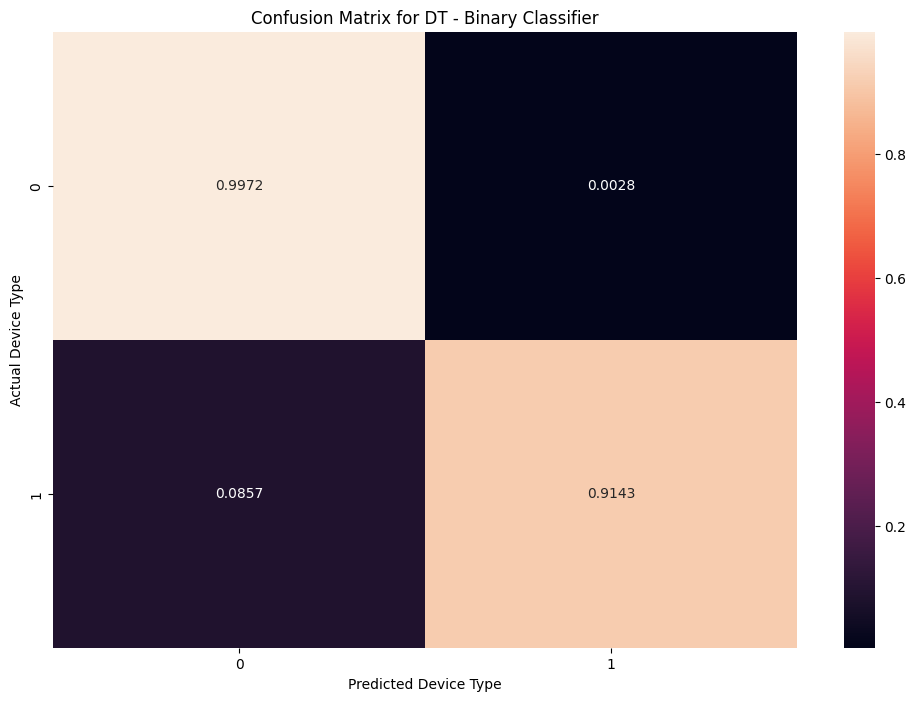

In [28]:
# creating a confusion matrix 
cnf_matrix_dt = metrics.confusion_matrix(y_test,y_pred)
normalized_cnf_matrix_dt = cnf_matrix_dt.astype('float')/cnf_matrix_dt.sum(axis = 1)[:,np.newaxis] 
plt.figure(figsize = (12,8))
sns.heatmap(normalized_cnf_matrix_dt,annot = True,fmt = '.4f',
           xticklabels = label_encoder.classes_,
           yticklabels = label_encoder.classes_)
plt.xlabel('Predicted Device Type')
plt.ylabel('Actual Device Type')
plt.title(f'Confusion Matrix for DT - Binary Classifier')
plt.show()

In [29]:
clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)

In [30]:
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test, y_pred, average = 'macro')
recall = metrics.recall_score(y_test, y_pred, average = 'macro')
f1_score = metrics.f1_score(y_test,y_pred,average='macro')

# printing the metrics (macro values for precision, recall and F1-Score)
print(f'Metrics for the Random Forest Classifier: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1_Score: {f1_score:.4f}')

Metrics for the Random Forest Classifier: 
Accuracy: 0.9953
Precision: 0.9532
Recall: 0.9719
F1_Score: 0.9623


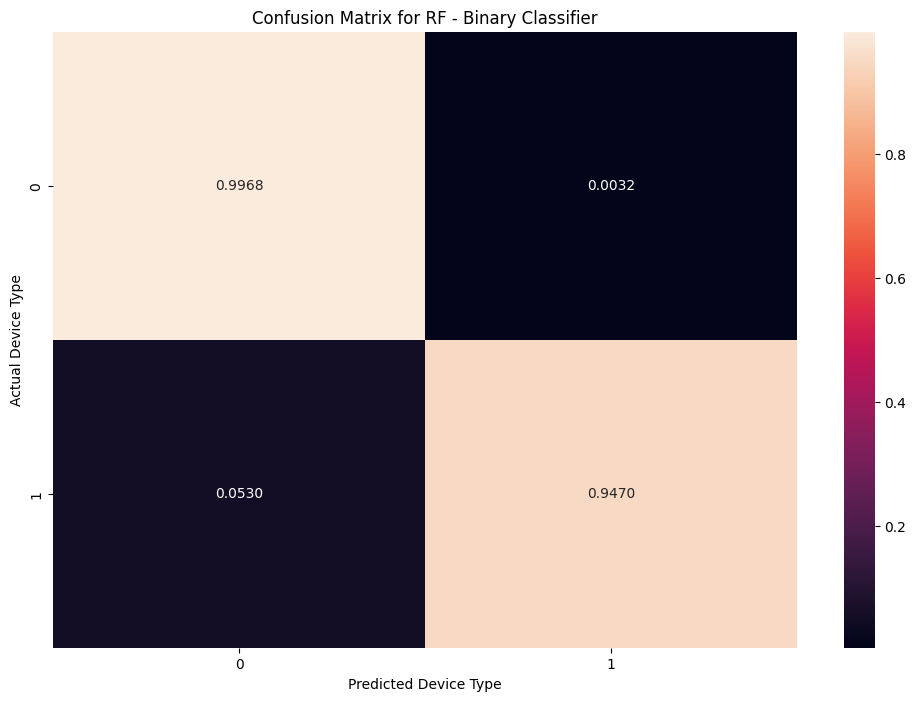

In [31]:
# creating a confusion matrix 
cnf_matrix_rf = metrics.confusion_matrix(y_test,y_pred)
normalized_cnf_matrix_rf = cnf_matrix_rf.astype('float')/cnf_matrix_dt.sum(axis = 1)[:,np.newaxis] 
plt.figure(figsize = (12,8))
sns.heatmap(normalized_cnf_matrix_rf,annot = True,fmt = '.4f',
           xticklabels = label_encoder.classes_,
           yticklabels = label_encoder.classes_)
plt.xlabel('Predicted Device Type')
plt.ylabel('Actual Device Type')
plt.title(f'Confusion Matrix for RF - Binary Classifier')
plt.show()

# Results - Set 1

If we try to classify on basis of the labels: (0 and 1 for attack v/s non-attack devices)
Combining fft feature vector and normal feature vector

### Metrics for the Decision Tree Classifier: 
###### Accuracy: 0.9940
###### Precision: 0.9538
###### Recall: 0.9498
###### F1_Score: 0.9518

### Metrics for the Random Forest Classifier: 
###### Accuracy: 0.9949
###### Precision: 0.9512
###### Recall: 0.9689
###### F1_Score: 0.9599

In [32]:
X = pd.concat([data[numeric_columns],fft_data],axis = 1)
y = data['attack_cat']

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [34]:
# clf_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 22, min_samples_split = 4, random_state = None)
clf_dt2 = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 22,
                                                         max_features = 20, max_leaf_nodes = None,
                                                         min_impurity_decrease = 0.0,
                                                         min_samples_leaf = 1, min_samples_split = 4,
                                                         min_weight_fraction_leaf = 0.0,
                                                         random_state = None, splitter = 'best')
# clf_rf = RandomForestClassifier(n_estimators = 75, criterion = 'entropy', min_samples_split = 10, random_state = None)
clf_rf2 = RandomForestClassifier(bootstrap = True, class_weight = None,
                                                         criterion = 'gini', min_impurity_decrease=0.0,
                                                         min_samples_leaf = 1, min_samples_split = 10,
                                                         min_weight_fraction_leaf = 0.0, n_estimators = 70,
                                                         n_jobs = None, oob_score = False, random_state = None,
                                                         verbose = 0, warm_start = False)

In [35]:
clf_dt2.fit(X_train,y_train)
y_pred = clf_dt2.predict(X_test)

In [36]:
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test, y_pred, average = 'macro')
recall = metrics.recall_score(y_test, y_pred, average = 'macro')
f1_score = metrics.f1_score(y_test,y_pred,average='macro')

# printing the metrics (macro values for precision, recall and F1-Score)
print(f'Metrics for the Decision Tree Classifier: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1_Score: {f1_score:.4f}')

Metrics for the Decision Tree Classifier: 
Accuracy: 0.9869
Precision: 0.4609
Recall: 0.4603
F1_Score: 0.4596


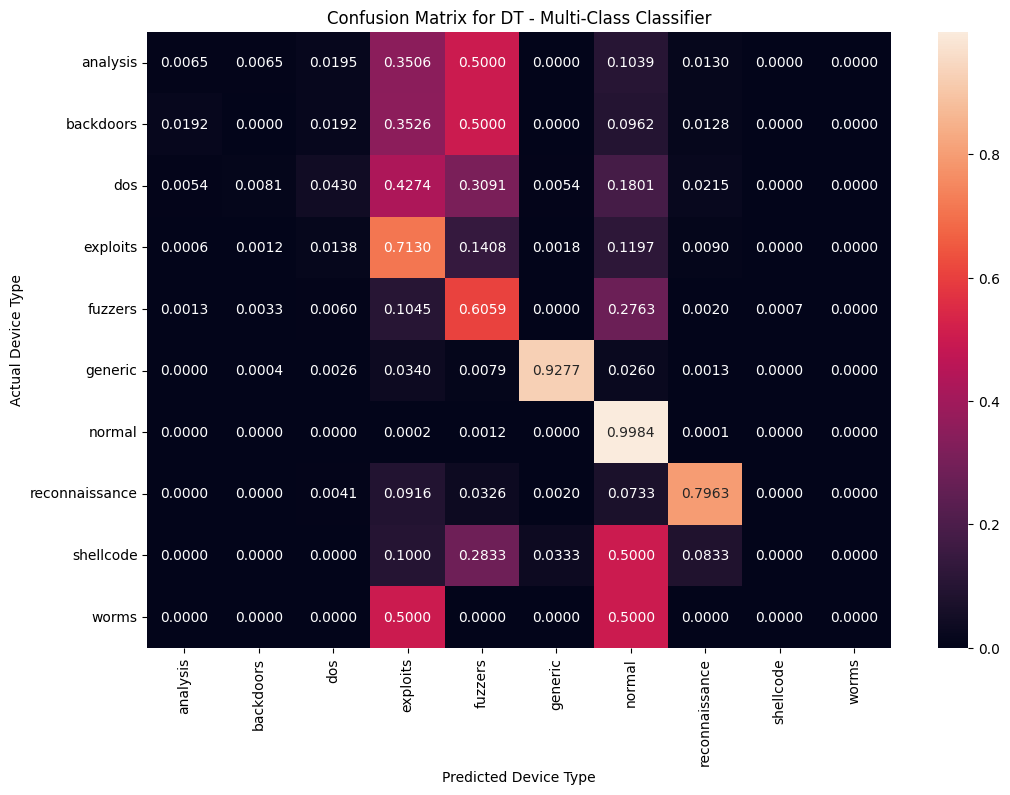

In [42]:
# creating a confusion matrix 
cnf_matrix_dt = metrics.confusion_matrix(y_test,y_pred)
normalized_cnf_matrix_dt = cnf_matrix_dt.astype('float')/cnf_matrix_dt.sum(axis = 1)[:,np.newaxis] 
plt.figure(figsize = (12,8))
sns.heatmap(normalized_cnf_matrix_dt,annot = True,fmt = '.4f',
           xticklabels = label_encoder.classes_,
           yticklabels = label_encoder.classes_)
plt.xlabel('Predicted Device Type')
plt.ylabel('Actual Device Type')
plt.title(f'Confusion Matrix for DT - Multi-Class Classifier')
plt.show()

In [38]:
clf_rf2.fit(X_train,y_train)
y_pred = clf_rf2.predict(X_test)

In [39]:
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test, y_pred, average = 'macro')
recall = metrics.recall_score(y_test, y_pred, average = 'macro')
f1_score = metrics.f1_score(y_test,y_pred,average='macro')

# printing the metrics (macro values for precision, recall and F1-Score)
print(f'Metrics for the Random Forest Classifier: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1_Score: {f1_score:.4f}')

C:\Users\Khush Bhuta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics for the Random Forest Classifier: 
Accuracy: 0.9887
Precision: 0.4423
Recall: 0.4091
F1_Score: 0.4127


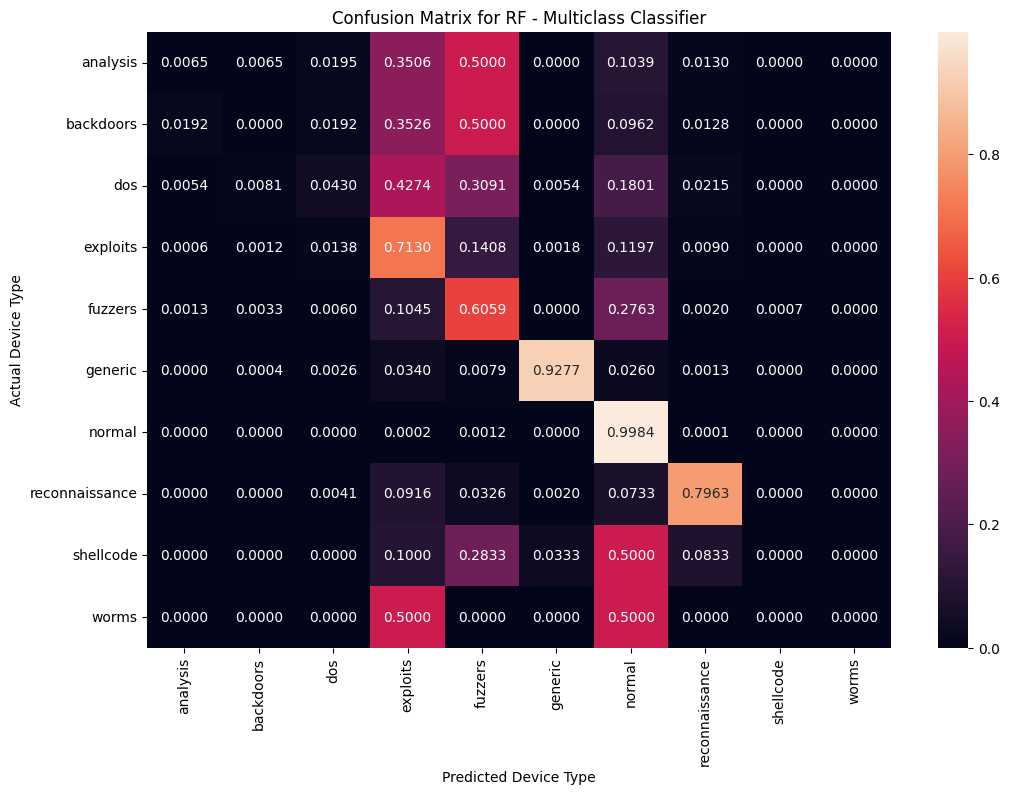

In [44]:
# creating a confusion matrix 
cnf_matrix_rf = metrics.confusion_matrix(y_test,y_pred)
normalized_cnf_matrix_rf = cnf_matrix_rf.astype('float')/cnf_matrix_dt.sum(axis = 1)[:,np.newaxis] 
plt.figure(figsize = (12,8))
sns.heatmap(normalized_cnf_matrix_rf,annot = True,fmt = '.4f',
           xticklabels = label_encoder.classes_,
           yticklabels = label_encoder.classes_)
plt.xlabel('Predicted Device Type')
plt.ylabel('Actual Device Type')
plt.title(f'Confusion Matrix for RF - Multiclass Classifier')
plt.show()

# Results - Set 2

If we try to classify on basis of the attack_cat (category): (normal v/s other attack devices)
Combining fft feature vector and normal feature vector

### Metrics for the Decision Tree Classifier:
###### Accuracy: 0.9874
###### Precision: 0.5071
###### Recall: 0.4623
###### F1_Score: 0.4696

### Metrics for the Random Forest Classifier: 
###### Accuracy: 0.9887
###### Precision: 0.4802
###### Recall: 0.4091
###### F1_Score: 0.4137

These low values of Precision, Accuracy, Recall and F1-Score indicated an imbalanced dataset. We fail to identify the minority classes effectively. The class imbalance here is due to the high count of 'normal' category. 